In [2]:
"""Produces time series"""
from typing import List, Tuple
import datetime
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype
#Open charts in new windows
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

COMMENTS_DATA = "wallstreetbets-posts-and-comments-for-august-2021-comments.csv"
STOCK_DATA = ""

/tmp/ipykernel_1349/2496901650.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def comments():
    """Returns a dataframe of the commment table. It has the timestamp, comment body and sentiment scores.
    Records without a """
    df = pd.read_csv("wallstreetbets-posts-and-comments-for-august-2021-comments.csv")
    df['datetime'] = pd.to_datetime(df.created_utc, unit='s').dt.tz_localize('UTC') #get timestamps
    df.set_index('datetime', inplace=True)
    df = df[['body', 'sentiment']] #pick certain columns
    df =  df[df.sentiment.notna()] #extract rows with existing sentiment scores
    
    gme_mentions = df.body.str.contains("GME", case=False)
    gamestop_mentions = df.body.str.contains("gamestop", case=False)
    return df[gamestop_mentions | gme_mentions]

def sentiment() -> pd.Series:
    """Returns a series object that contains the sentiment of each comment"""
    return comments().sentiment

def stock_data() -> pd.DataFrame:
    df = pd.read_csv("alphavantage_data_GME_2021-08.csv")
    df['datetime'] = pd.to_datetime(df.timestamp)
    return df.set_index('datetime')

def stock_price(stockFrame : pd.DataFrame) -> pd.Series:
    """Returns a series object for the opening price of the stock data"""
    return stockFrame.open

def stock_volume(stockFrame : pd.DataFrame) -> pd.Series:
    """Returns a series object for the traded volume of the stock"""
    volume = stockFrame.volume
    # volume.name = 'Traded Volume'
    return volume

In [4]:
def chat_velocity(sentiment : pd.Series) -> pd.Series:
    """Group comment count into 5min intervals, returns a Series object"""
    return sentiment.resample('5min').size()

def log_normal(series : pd.Series) -> pd.Series:
    """Performs log(x_n+1/x_n) on each item"""
    pass

In [20]:
#Sentiment of each comment and  market price against time, in August 2021

def plotTwoSeries(red : pd.Series, blue : pd.Series) -> None:
    """Plots both the given series. Both series need to have an datetime index"""
    fig, red_ax = plt.subplots()
    blue_ax = red_ax.twinx()

    plt.ticklabel_format(style='plain')
    red_plot, = red_ax.plot(red, color='red', label=red.name)
    blue_plot, = blue_ax.plot(blue, color='blue', label=blue.name)

    red_ax.xlabel = 'Time'
    red_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True)) #TODO: Add a y-axis limit at 0?
    blue_ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    red_ax.set(ylabel=red.name)
    blue_ax.set(ylabel=blue.name)

    fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')
    plt.title(f"{red.name} vs {blue.name}")
    plt.legend(handles=[red_plot, blue_plot])
    plt.show()

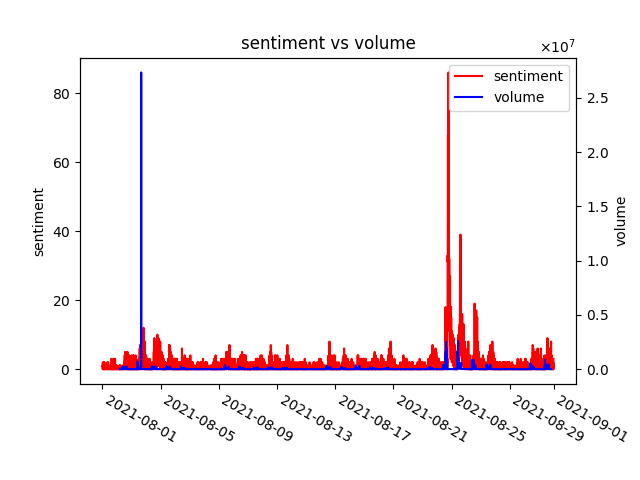

In [21]:
plotTwoSeries(chat_velocity(sentiment()), stock_volume(stock_data()))